In [1]:
import numpy as np
import seaborn as sns
import ipywidgets as widgets
import matplotlib.pyplot as plt
import itertools
from scipy.spatial import ConvexHull
%matplotlib notebook
sns.set()

# Market rate for carrots and potatoes

In [2]:
def ratio_widget():
    return widgets.FloatLogSlider(value=1, base=2, min=-5, max=5, step=.25)
def clean_plot(f):
    """Boilerplate to let f draw stuff"""
    global fig
    def g(*args, clean=True, **kwargs):
        global fig
        if clean:
            fig.clf()
        answer = f(*args, **kwargs)
        if clean:
            fig.show()
        return answer
    return g

In [3]:
bounds = {
    "alice": {
        "potato": 1,
        "carrot": 5,
        "color": "blue",
    },
    "bob": {
        "potato": 6,
        "carrot": 1,
        "color": "yellow",
    },
}

def check_bounds(bounds, farmer, potato, carrot):
    """Check that the given farmer can produce the given amounts of vegetables"""
    return potato/bounds[farmer]["potato"] + carrot/bounds[farmer]["carrot"] <= 1

def get_linear_price(ratio):
    """Return a bilinear price function"""
    def price(potato, carrot):
        potato_price = 1  # €/potato
        carrot_price = potato_price*ratio
        return potato*potato_price + carrot*carrot_price
    return price

<IPython.core.display.Javascript object>


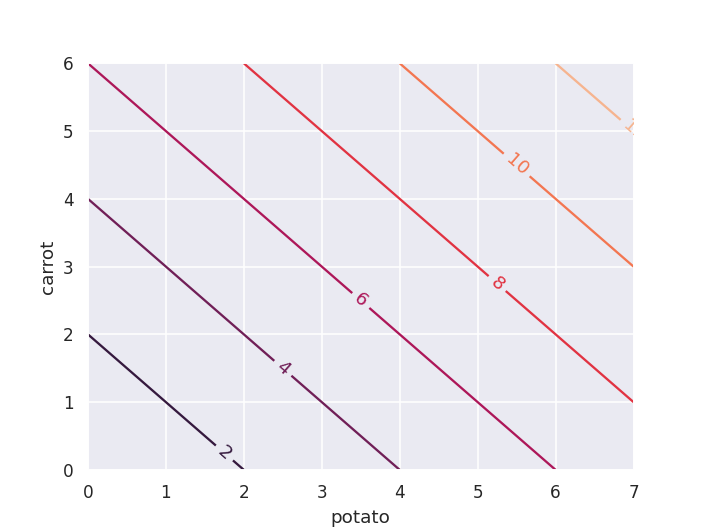

interactive(children=(FloatLogSlider(value=1.0, base=2.0, description='ratio', max=5.0, min=-5.0, step=0.25), …

<function __main__.clean_plot.<locals>.g(*args, clean=True, **kwargs)>

In [4]:
@clean_plot
def plot_market_landscape(ratio):
    X,Y = np.meshgrid(np.linspace(0, sum([bounds[f]["potato"] for f in bounds if f != "both"]), num=5),
                      np.linspace(0, sum([bounds[f]["carrot"] for f in bounds if f != "both"]), num=5))
    Z = get_linear_price(ratio)(X, Y)
    cs = plt.contour(X, Y, Z)
    plt.clabel(cs)
    plt.xlabel("potato")
    plt.ylabel("carrot")

fig = plt.figure()
widgets.interact(plot_market_landscape, ratio=ratio_widget(), clean=widgets.fixed(True))

<IPython.core.display.Javascript object>


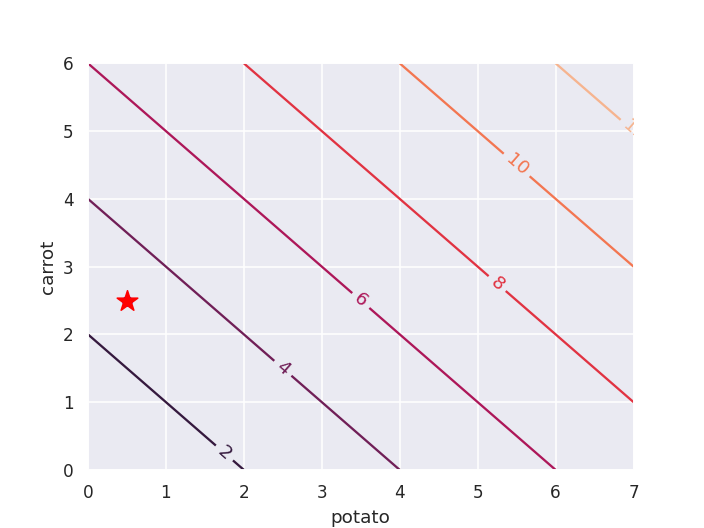

interactive(children=(FloatLogSlider(value=1.0, base=2.0, description='ratio', max=5.0, min=-5.0, step=0.25), …

<function __main__.clean_plot.<locals>.g(*args, clean=True, **kwargs)>

In [5]:
def best(ratio, *args):
    """Return the best of the (potato, carrot) couples given in arguments"""
    price = get_linear_price(ratio)
    best_price = -float("inf")
    best_potato = None
    best_carrot = None
    for potato, carrot in args:
        if potato is not None and carrot is not None and \
        (p := price(potato, carrot)) > best_price:
            best_potato = potato
            best_carrot = carrot
            best_price = p
    return best_price, best_potato, best_carrot

class State:
    def __init__(self, ratio):
        self._ratio = ratio
        self.best_price, self.best_potato, self.best_carrot = best(ratio)

    @property
    def ratio(self):
        return self._ratio
    
    @ratio.setter
    def ratio(self, ratio):
        """Reset the state if the ratio changes"""
        if ratio != self._ratio:
            self.__init__(ratio)
            
    def scatter(self):
        """Plot the best known point so far"""
        if self.best_potato is None and self.best_carrot is None:
            return
        print(f'Best so far: {self.best_price}')
        plt.scatter(self.best_potato,
                    self.best_carrot,
                    color="red", marker="*", s=200)
    
    @property
    def current_vegetables(self):
        return self._current_vegetables
    
    @current_vegetables.setter
    def current_vegetables(self, vegetables):
        potato, carrot = vegetables
        self.best_price, self.best_potato, self.best_carrot = best(
            self._ratio,
            [self.best_potato, self.best_carrot],
            [potato, carrot])
            
state = State(None)
@clean_plot
def plot_farmer(farmer, ratio, potato, carrot):
    """Plot the given point for the given farmer, along with the best point so far"""
    global state
    state.ratio = ratio
    plot_market_landscape(ratio, clean=False)
    answer = f"{farmer} can't produce that much"
    if check_bounds(bounds, farmer, potato, carrot):
        state.current_vegetables = [potato, carrot]
        plt.scatter(potato, carrot, color="blue")
        answer = get_linear_price(ratio)(potato, carrot)
    state.scatter()
    return answer

fig = plt.figure()
widgets.interact(plot_farmer, farmer=widgets.fixed("alice"),
                 ratio=ratio_widget(),
                 potato=(0., bounds["alice"]["potato"]),
                 carrot=(0., bounds["alice"]["carrot"]),
                 clean=widgets.fixed(True))

In [6]:
def envelope(bounds, farmers):
    """Returns the coordinates of the feasible zone for the given farmers"""
    # First collect all the extreme points, i.e. those where each farmer goes either full potato
    # or full carrot
    points = [[0, 0]]
    for combination in itertools.product(*[["potato", "carrot"]]*len(farmers)):
        # Combination is the list of words of length n with alphabet ["potato", "carrot"]
        current_point = {"potato": 0, "carrot": 0}
        for farmer, vegetable in zip(farmers, combination):
            current_point[vegetable] += bounds[farmer][vegetable]
        points += [[current_point["potato"], current_point["carrot"]]]
    points = np.array(points)
    # Now we compute the convex hull of this
    hull = ConvexHull(points)
    return points[hull.vertices, 0], points[hull.vertices, 1]
    

<IPython.core.display.Javascript object>


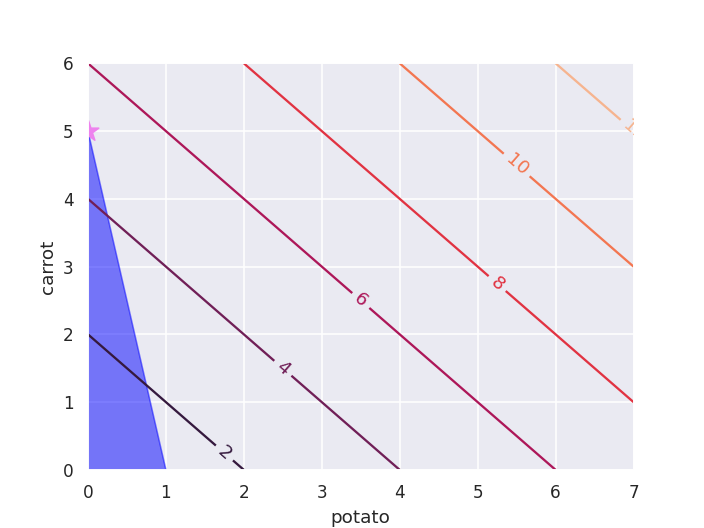

interactive(children=(FloatLogSlider(value=1.0, base=2.0, description='ratio', max=5.0, min=-5.0, step=0.25), …

<function __main__.clean_plot.<locals>.g(*args, clean=True, **kwargs)>

In [7]:
@clean_plot
def plot_feasible_zone(bounds, farmer, color, ratio):
    plot_market_landscape(ratio, clean=False)
    feasible_zone_potato, feasible_zone_carrot = envelope(bounds, farmer)
    plt.fill(feasible_zone_potato,
             feasible_zone_carrot,
             color = color,  alpha=.5)
    price, potato, carrot = best(ratio, 
                             *[[potato, carrot] 
                               for potato, carrot in zip(feasible_zone_potato, feasible_zone_carrot)])
    plt.scatter(potato, carrot, color="violet", marker="*", s=200)
    return price

fig = plt.figure()
widgets.interact(plot_feasible_zone, bounds=widgets.fixed(bounds),
                 farmer=widgets.fixed(["alice"]), color=widgets.fixed("blue"),
                 ratio=ratio_widget(), clean=widgets.fixed(True))

<IPython.core.display.Javascript object>


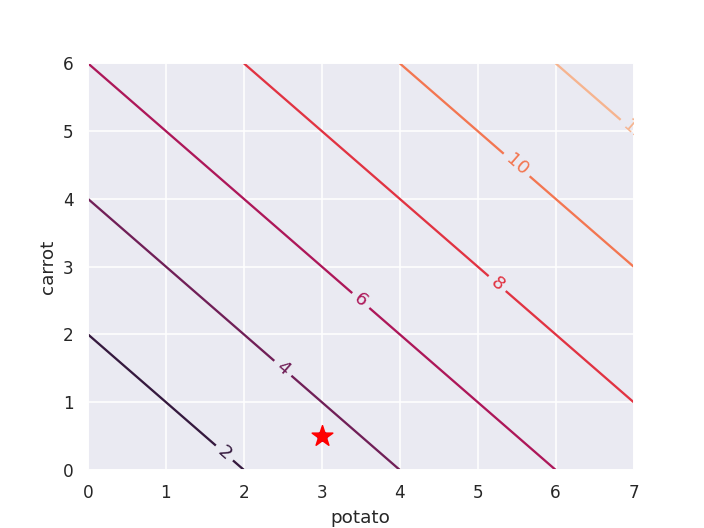

interactive(children=(FloatLogSlider(value=1.0, base=2.0, description='ratio', max=5.0, min=-5.0, step=0.25), …

<function __main__.clean_plot.<locals>.g(*args, clean=True, **kwargs)>

In [8]:
fig = plt.figure()
state.ratio = None
widgets.interact(plot_farmer, farmer=widgets.fixed("bob"), ratio=ratio_widget(),
                 potato=(0., bounds["bob"]["potato"]),
                 carrot=(0., bounds["bob"]["carrot"]),
                 clean=widgets.fixed(True))

<IPython.core.display.Javascript object>


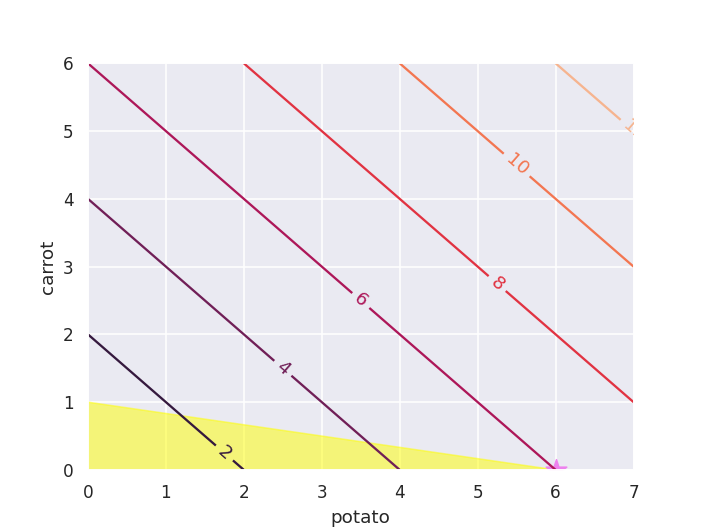

interactive(children=(FloatLogSlider(value=1.0, base=2.0, description='ratio', max=5.0, min=-5.0, step=0.25), …

<function __main__.clean_plot.<locals>.g(*args, clean=True, **kwargs)>

In [9]:
fig = plt.figure()
widgets.interact(plot_feasible_zone, bounds=widgets.fixed(bounds),
                 farmer=widgets.fixed(["bob"]), color=widgets.fixed("yellow"),
                 ratio=ratio_widget(), clean=widgets.fixed(True))

<IPython.core.display.Javascript object>


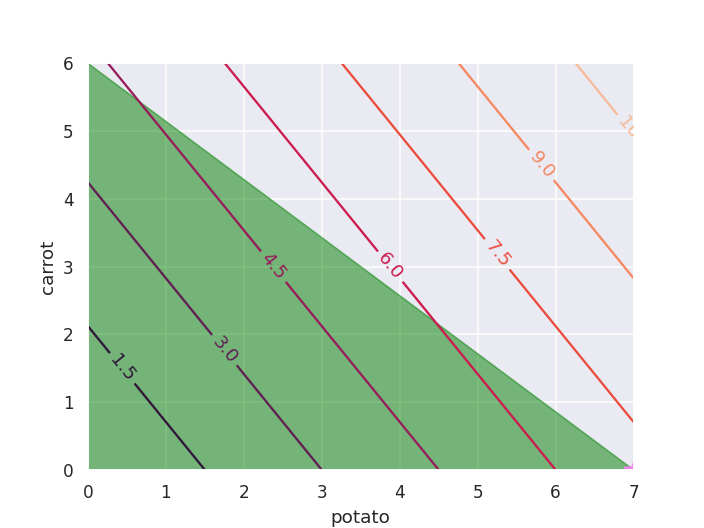

interactive(children=(FloatLogSlider(value=1.0, base=2.0, description='ratio', max=5.0, min=-5.0, step=0.25), …

<function __main__.clean_plot.<locals>.g(*args, clean=True, **kwargs)>

In [13]:
fig = plt.figure()
bothbounds = {"both":{"potato": sum(bounds[f]["potato"] for f in ["alice", "bob"]),
                     "carrot": sum(bounds[f]["carrot"] for f in ["alice", "bob"])}}
widgets.interact(plot_feasible_zone, bounds=widgets.fixed(bothbounds),
                 farmer=widgets.fixed(["both"]), color=widgets.fixed("green"),
                 ratio=ratio_widget(), clean=widgets.fixed(True))

<IPython.core.display.Javascript object>


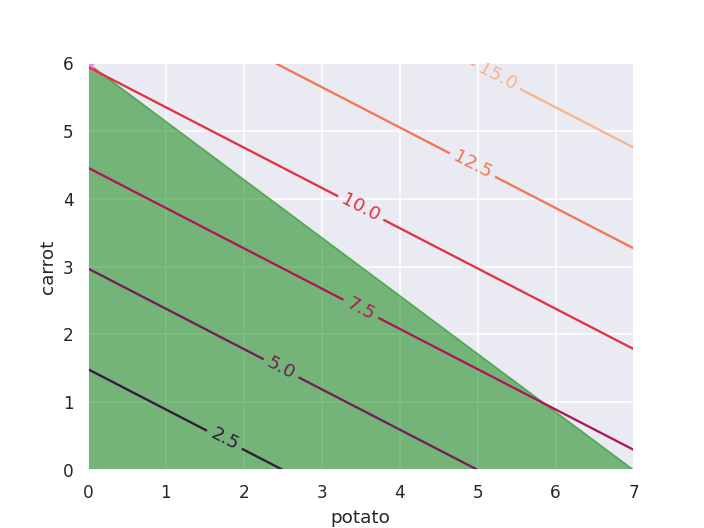

interactive(children=(FloatLogSlider(value=1.0, base=2.0, description='ratio', max=5.0, min=-5.0, step=0.25), …

<function __main__.clean_plot.<locals>.g(*args, clean=True, **kwargs)>

In [12]:
state.ratio = None
@clean_plot
def plot_both_farmers_naive(ratio, alice_potato, alice_carrot, bob_potato, bob_carrot):
    """Plot the given point, along with the best point so far"""
    global state
    state.ratio = ratio
    plot_feasible_zone(farmer=["both"], bounds=bothbounds, ratio=ratio, clean=False, color="green")
    if not check_bounds(bounds, "alice", alice_potato, alice_carrot):
        return "Alice can't produce that much"
    if not check_bounds(bounds, "bob", bob_potato, bob_carrot):
        return "Bob can't produce that much"
    potato = alice_potato + bob_potato
    carrot = alice_carrot + bob_carrot
    state.current_vegetables = [potato, carrot]
    plt.scatter(potato, carrot, color="green")
    state.scatter()
    return get_linear_price(ratio)(potato, carrot)

fig = plt.figure()
widgets.interact(plot_both_farmers_naive, ratio=ratio_widget(),
                 clean=widgets.fixed(True),
                 alice_potato=(0., bounds["alice"]["potato"]),
                 alice_carrot=(0., bounds["alice"]["carrot"]),
                 bob_potato=(0., bounds["bob"]["potato"]),
                 bob_carrot=(0., bounds["bob"]["carrot"]),
                )

<IPython.core.display.Javascript object>


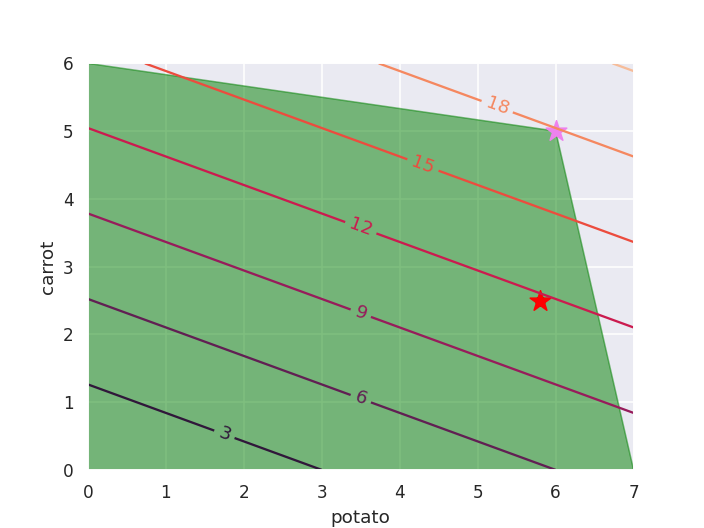

interactive(children=(FloatLogSlider(value=1.0, base=2.0, description='ratio', max=5.0, min=-5.0, step=0.25), …

<function __main__.clean_plot.<locals>.g(*args, clean=True, **kwargs)>

In [15]:
state.ratio = None
@clean_plot
def plot_both_farmers_naive(ratio, alice_potato, alice_carrot, bob_potato, bob_carrot):
    """Plot the given point, along with the best point so far"""
    global state
    state.ratio = ratio
    plot_feasible_zone(farmer=["alice", "bob"], bounds=bounds, ratio=ratio, clean=False, color="green")
    if not check_bounds(bounds, "alice", alice_potato, alice_carrot):
        return "Alice can't produce that much"
    if not check_bounds(bounds, "bob", bob_potato, bob_carrot):
        return "Bob can't produce that much"
    potato = alice_potato + bob_potato
    carrot = alice_carrot + bob_carrot
    state.current_vegetables = [potato, carrot]
    plt.scatter(potato, carrot, color="green")
    state.scatter()
    return get_linear_price(ratio)(potato, carrot)

fig = plt.figure()
widgets.interact(plot_both_farmers_naive, ratio=ratio_widget(),
                 alice_potato=(0., bounds["alice"]["potato"]),
                 alice_carrot=(0., bounds["alice"]["carrot"]),
                 bob_potato=(0., bounds["bob"]["potato"]),
                 bob_carrot=(0., bounds["bob"]["carrot"]),
                 clean=widgets.fixed(True)
                )